## Using Deep Learning for Market Movement Prediction

#### The Simple Classification Problem Revisited 

In [134]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
                  2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
                  4.5, 4.75, 5., 5.5])

In [135]:
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
                    0, 1, 1, 1, 1, 1, 1]) 

In [136]:
data = pd.DataFrame({'hours': hours, 'success': success})

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hours    20 non-null     float64
 1   success  20 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 448.0 bytes


In [138]:
from sklearn.neural_network import MLPClassifier

In [139]:
model = MLPClassifier(hidden_layer_sizes=[32],
                     max_iter=1000, random_state=100)

In [140]:
model.fit(data['hours'].values.reshape(-1, 1), data['success'])

MLPClassifier(hidden_layer_sizes=[32], max_iter=1000, random_state=100)

In [141]:
data['prediction'] = model.predict(data['hours'].values.reshape(-1, 1)) # <2>

In [142]:
data.tail()

,hours,success,prediction
15,4.25,1,1
16,4.50,1,1
17,4.75,1,1
18,5.00,1,1
19,5.50,1,1


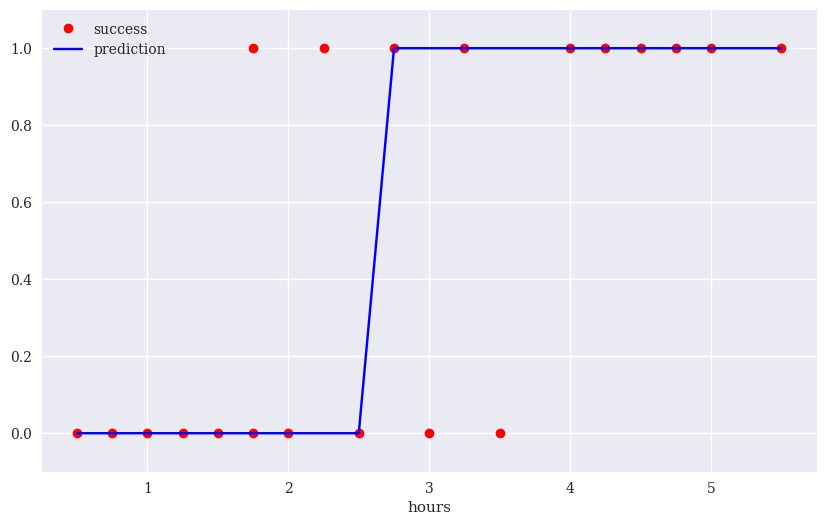

In [143]:
data.plot(x='hours', y=['success', 'prediction'],
          style=['ro', 'b-'], ylim=[-.1, 1.1],
          figsize=(10, 6));

### Using Deep Neural Networks to Predict Market Direction

In [144]:
symbol = 'EUR='

In [145]:
data = pd.DataFrame(raw[symbol])

In [146]:
data.rename(columns={symbol: 'price'}, inplace=True)

In [147]:
data['return'] = np.log(data['price'] /
                         data['price'].shift(1)) 

In [148]:
data['direction'] = np.where(data['return'] > 0, 1, 0)

In [149]:
lags = 5


In [150]:
cols = []
for lag in range(1, lags + 1): # <5>
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag) # <6>
    cols.append(col)
data.dropna(inplace=True) # <7>

In [151]:
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


In [152]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [153]:
optimizer = Adam(learning_rate=0.0001)

In [154]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [155]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
        input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [156]:
cutoff = '2017-12-31'

In [157]:
training_data = data[data.index < cutoff].copy()

In [158]:
mu, std = training_data.mean(), training_data.std()

In [159]:
training_data_ = (training_data - mu) / std

In [160]:
test_data = data[data.index >= cutoff].copy()

In [161]:
test_data_ = (test_data - mu) / std

In [162]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

2023-10-07 08:12:28.449908: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


CPU times: user 2.38 s, sys: 602 ms, total: 2.98 s
Wall time: 2.07 s


In [163]:
res = pd.DataFrame(model.history.history)

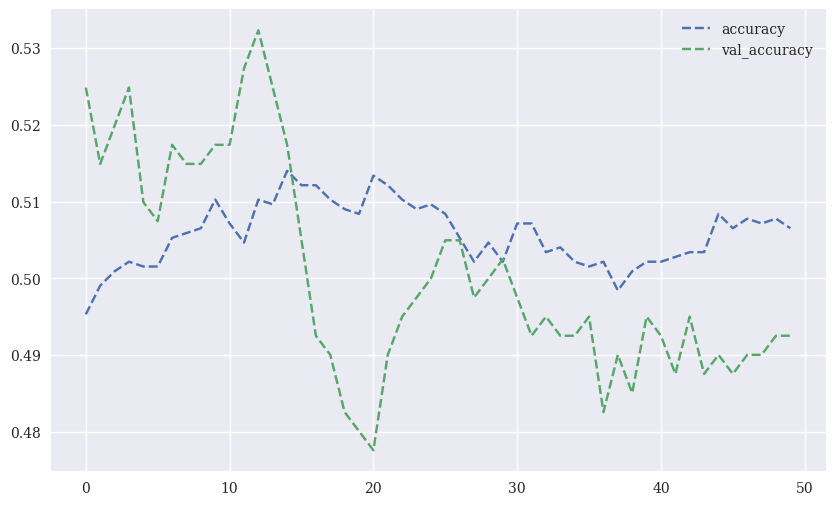

In [164]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [165]:
model.evaluate(training_data_[cols], training_data['direction'])

63/63 [==============================] - 0s 398us/step - loss: 0.8356 - accuracy: 0.5152


[0.8355799913406372, 0.5151968002319336]

In [166]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

63/63 [==============================] - 0s 325us/step


In [167]:
pred[:30].flatten()

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [168]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [169]:
training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])

In [170]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.826569
strategy    1.040103
dtype: float64

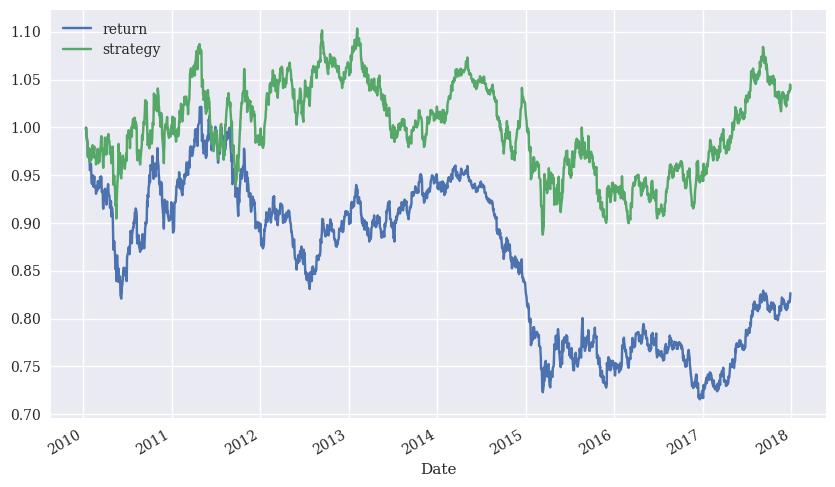

In [171]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch05/dl_plot_2.png')

In [172]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 [==============================] - 0s 481us/step - loss: 0.7921 - accuracy: 0.4553


[0.7921297550201416, 0.45526838302612305]

In [173]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

16/16 [==============================] - 0s 420us/step


In [174]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [175]:
test_data['prediction'].value_counts()

prediction
 1    406
-1     97
Name: count, dtype: int64

In [176]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [177]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    0.864271
dtype: float64

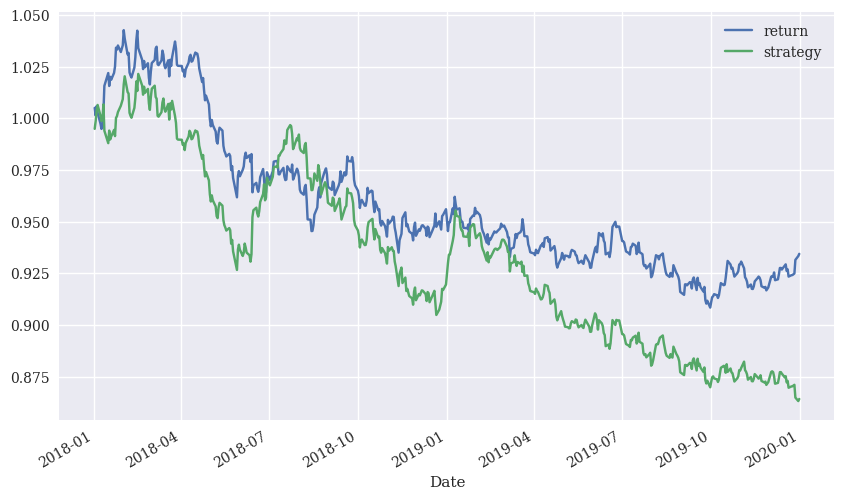

In [178]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

### Adding Different Types of Features

In [179]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)

In [180]:
data['volatility'] = data['return'].rolling(20).std().shift(1)

In [181]:
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)

In [182]:
data.dropna(inplace=True)

In [183]:
cols.extend(['momentum', 'volatility', 'distance'])

In [184]:
print(data.round(4).tail())

             price  return  direction   lag_1   lag_2   lag_3   lag_4   lag_5  \
Date                                                                            
2019-12-24  1.1087  0.0001          1  0.0007 -0.0038  0.0008 -0.0034  0.0006   
2019-12-26  1.1096  0.0008          1  0.0001  0.0007 -0.0038  0.0008 -0.0034   
2019-12-27  1.1175  0.0071          1  0.0008  0.0001  0.0007 -0.0038  0.0008   
2019-12-30  1.1197  0.0020          1  0.0071  0.0008  0.0001  0.0007 -0.0038   
2019-12-31  1.1210  0.0012          1  0.0020  0.0071  0.0008  0.0001  0.0007   

            momentum  volatility  distance  
Date                                        
2019-12-24   -0.0010      0.0024    0.0005  
2019-12-26   -0.0011      0.0024    0.0004  
2019-12-27   -0.0003      0.0024    0.0012  
2019-12-30    0.0010      0.0028    0.0089  
2019-12-31    0.0021      0.0028    0.0110  


In [185]:
training_data = data[data.index < cutoff].copy()

In [186]:
mu, std = training_data.mean(), training_data.std()

In [187]:
training_data_ = (training_data - mu) / std

In [188]:
test_data = data[data.index >= cutoff].copy() 

In [189]:
test_data_ = (test_data - mu) / std

In [190]:
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu',
                input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [191]:
%%time 
model.fit(training_data_[cols], training_data['direction'],
          verbose=False, epochs=25)

CPU times: user 952 ms, sys: 218 ms, total: 1.17 s
Wall time: 807 ms


In [192]:
model.evaluate(training_data_[cols], training_data['direction'])

62/62 [==============================] - 0s 423us/step - loss: 0.6822 - accuracy: 0.5621


[0.68216472864151, 0.5620847940444946]

In [193]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

62/62 [==============================] - 0s 345us/step


In [194]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [195]:
training_data['strategy'] = training_data['prediction'] * \
                            training_data['return']

In [196]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.901074
strategy    3.127172
dtype: float64

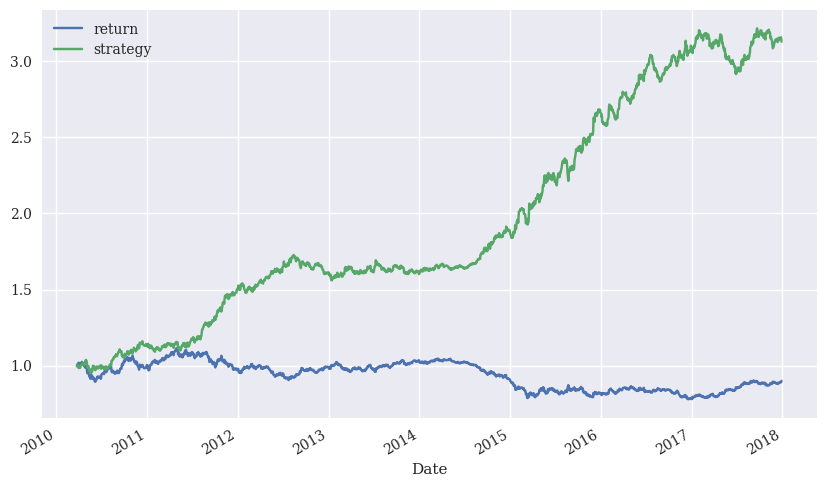

In [197]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

In [198]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 [==============================] - 0s 544us/step - loss: 0.6929 - accuracy: 0.5249


[0.6929448843002319, 0.5248509049415588]

In [199]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

16/16 [==============================] - 0s 381us/step


In [200]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [201]:
test_data['prediction'].value_counts()

prediction
-1    356
 1    147
Name: count, dtype: int64

In [202]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [203]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.178173
dtype: float64

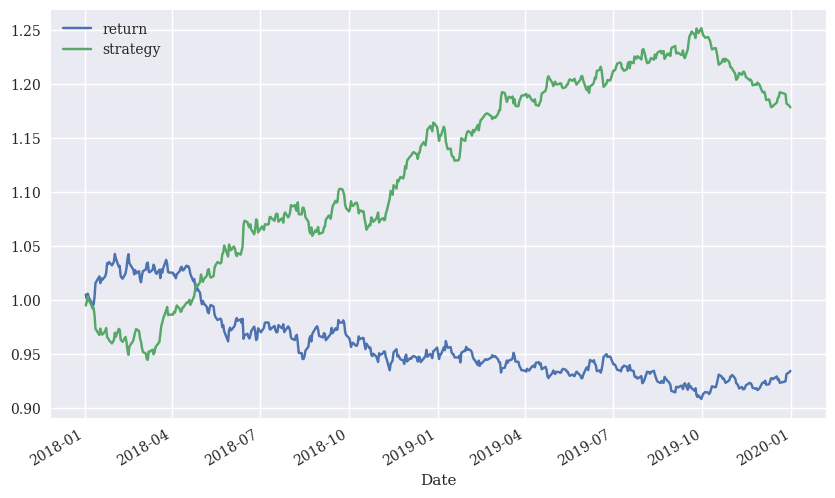

In [204]:
test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));